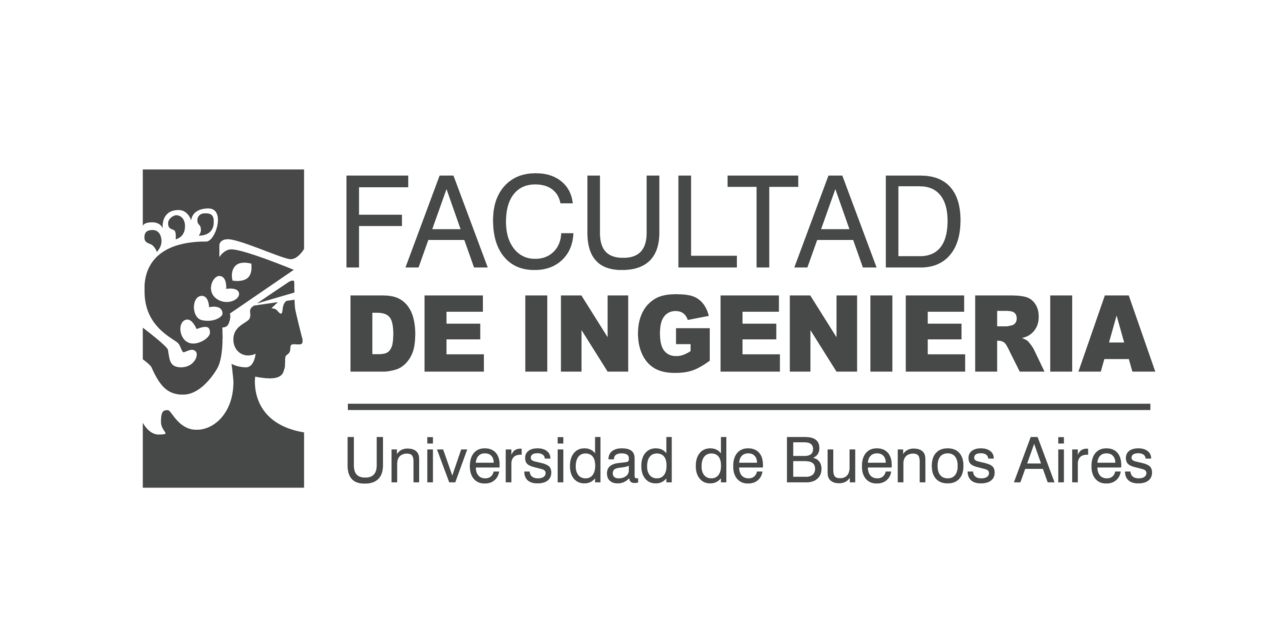

## Aprendizaje Profundo - TP2
### Cohorte 18 - 1er bimestre 2025

**Profesores:** <br />
Dr. Ing. Marcos Maillot - marcos_maillot@yahoo.com.ar <br />
Dr. Antonio Zarauz - hedrergudene@gmail.com <br />
Mg. Ing. Gerardo Vilcamiza - gerardox2000@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-aprendizaje-profundo <br />

## Consigna: **Clasificador de Emociones**

Este segundo TP comienza desde el día después de la clase 5 (2 de abril) y la ventana de entrega estará abierta hasta las **23hs del miércoles 23 de abril (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un link a un notebook de google colab (permitir acceso a gerardo.vilcamiza@ieee.org y gvilcamiza.ext@fi.uba.ar) y **se realizará en el siguiente link de google forms: [link](https://forms.gle/XatA691so4eVxZB68)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co18.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/10EWwOriegjawQ3evl1nuIldY3pUR-hQc/view?usp=sharing

## Prerequisitos y dependencias

In [ ]:
%pip install gdown
%pip install pandas
%pip install numpy
%pip install torch
%pip install torchinfo
%pip install torchvision
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

In [86]:
import os
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torchinfo as torchinfo
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset


# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# PARAMETROS GLOBALES
BATCH_SIZE = 128
WORKERS = 4
DATASET_AUGMENTED_SIZE = 30000

In [3]:
# Descarga dataset
!gdown --id 10EWwOriegjawQ3evl1nuIldY3pUR-hQc --output emotions_dataset.zip
!unzip emotions_dataset.zip -d emotions_dataset

/home/jgonzalez/dev/.virtualenvs/ceia-aprendizaje-profundo/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10EWwOriegjawQ3evl1nuIldY3pUR-hQc
From (redirected): https://drive.google.com/uc?id=10EWwOriegjawQ3evl1nuIldY3pUR-hQc&confirm=t&uuid=e25b7e8c-4010-40ab-a438-79dd33afea2a
To: /home/jgonzalez/dev/ceia-aprendizaje-profundo/tp2/emotions_dataset.zip
100%|██████████████████████████████████████| 39.9M/39.9M [00:01<00:00, 22.6MB/s]
Archive:  emotions_dataset.zip
   creating: emotions_dataset/dataset_emociones/
   creating: emotions_dataset/dataset_emociones/test/
   creating: emotions_dataset/dataset_emociones/test/alegria/
  inflating: emotions_dataset/dataset_emociones/test/alegria/test_0003_aligned.jpg  
  inflating: emotions_dataset/dataset_emociones/test/alegria/

## Utils

In [75]:
def dataset_analysis(dataset_path: str, train_counts: dict, test_counts: dict) -> None:
    """
    Analiza el dataset y cuenta la cantidad de imágenes por clase en train y test.

    Args:
        dataset_path (str): Ruta al dataset.
        train_counts (dict): Dict para contar imágenes en train.
        test_counts (dict): Dict para contar imágenes en test.
    """
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_path, split)
        print(f"Processing {split} split {split_path}...")
        if os.path.exists(split_path):
            for emotion in os.listdir(split_path):
                emotion_path = os.path.join(split_path, emotion)
                print(f"Processing emotion {emotion} in {emotion_path}...")
                if os.path.isdir(emotion_path):
                    image_count = len([img for img in os.listdir(emotion_path) if img.endswith(('.jpg'))])
                    if split == "train":
                        train_counts[emotion] += image_count
                    elif split == "test":
                        test_counts[emotion] += image_count
                        
def plot_class_distribution(train_counts: dict, test_counts: dict) -> None:
    """
    Plotea la distribución de clases en train y test.

    Args:
        train_counts (dict): Dict con imágenes en train.
        test_counts (dict): Dict con imágenes en test.
    """
    labels = train_counts.keys()
    train_values = train_counts.values()
    test_values = test_counts.values()
    total_train_images = sum(train_values)
    total_test_images = sum(test_values)

    x = np.arange(len(labels))  
    width = 0.35 

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label=f'Train (Total: {total_train_images})')
    rects2 = ax.bar(x + width/2, test_values, width, label=f'Test (Total: {total_test_images})')

    ax.set_xlabel('Clases de emociones')
    ax.set_ylabel('# de imagenes')
    ax.set_title('Distribución de clases en train y test')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()
    
def mean_std_dataset(dataset_path: str) -> tuple:
    """
    Calcula la media y desviación estándar de un dataset de imágenes.

    Args:
        dataset_path (str): Ruta al dataset.

    Returns:
        tuple: Media y desviación estándar por canal.
    """
    # Transformación base: solo ToTensor para que los valores estén entre 0 y 1
    transform = transforms.ToTensor()

    # Cargar el dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    # Calcular media
    print("Calculando media...")
    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        total_pixels += batch_samples * images.size(2) * images.size(3)  # H * W por imagen
        mean += images.sum(dim=[0, 2, 3])

    mean /= total_pixels

    # Calcular desviación estándar
    print("Calculando desviación estándar...")
    for images, _ in tqdm(loader):
        std += ((images - mean[None, :, None, None]) ** 2).sum(dim=[0, 2, 3])

    std = torch.sqrt(std / total_pixels)

    print(f"Media por canal: {mean}")
    print(f"Desviación estándar por canal: {std}")
    
    return mean, std

def denormalize(img_tensor: torch.Tensor, mean: list, std: list) -> torch.Tensor:
    """
    Desnormaliza un tensor de imagen.

    Args:
        img_tensor (torch.Tensor): Tensor de imagen a desnormalizar.
        mean (list): Lista con medias por canal.
        std (list): Lista con desviaciones estándar por canal.

    Returns:
        torch.Tensor: _description_
    """
    img = img_tensor.clone()
    for z_img, z_mean, z_std in zip(img, mean, std):
        z_img.mul_(z_std).add_(z_mean) # img = img * std + mean
    return img

def show_image(img_tensor: torch.Tensor, mean: list = None, std: list = None) -> None:
    """
    Mostrar una imagen a partir de un tensor de imagen.

    Args:
        img_tensor (torch.Tensor): Tensor de imagen a mostrar.
        mean (list, optional): Lista con medias por canal.
        std (list, optional): Lista con desviaciones estándar por canal.
    """
    if mean is not None and std is not None:
        img_tensor = denormalize(img_tensor, mean, std)

    img_np = img_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
    plt.imshow(img_np.clip(0, 1))  # clamp para estar seguros
    plt.axis('off')
    plt.show()

def show_first_images_per_class(
        dataset: torchvision.datasets.ImageFolder, 
        class_names: list,
        mean: float,
        std: float
    ) -> None:
    """
    Mostrar primera imagen de cada clase

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset a visualizar.
        class_names (list): Lista de clases del dataset.
    """
    images_by_class = {}
    
    # Recorrer el dataset y guardar la primera imagen de cada clase en images_by_class
    for img, label in dataset:
        if label not in images_by_class:
            images_by_class[label] = img
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(images_by_class.items()):
        img = denormalize(img, mean, std) 
        img = img.permute(1, 2, 0).numpy() # [3, H, W] → [H, W, 3]
        axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def map_counts_to_classnames(counter_dict: dict, class_names: list) -> dict:
    """
    Mapea los indices de las clases a sus nombres.

    Args:
        counter_dict (dict): Dict counter a mapear.
        class_names (list): Dict de nombres de clases.

    Returns:
        dict: _description_
    """
    return {class_names[k]: v for k, v in sorted(counter_dict.items())}

# igual a show_first_images_per_class pero con DataLoader 
def show_first_images_per_class_from_loader(
    dataloader: DataLoader,
    class_names: list,
    mean: list,
    std: list,
    cmap: str = None
) -> None:
    """
    Mostrar la primera imagen de cada clase desde un DataLoader con transformaciones activas.

    Args:
        dataloader (DataLoader): Dataloader a visualizar.
        class_names (list): Nombre de las clases dentro del dataset que tiene el DataLoader.
        mean (list): Media por canal.
        std (list): Desviación estándar por canal.
    """
    images_by_class = {}

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in images_by_class:
                images_by_class[label] = img
            if len(images_by_class) == len(class_names):
                break
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(sorted(images_by_class.items())):
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).numpy()
        if cmap:
            axes[i].imshow(img.clip(0, 1), cmap='gray')
        else:
            axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_train_results_from_json(json_file: str = 'train_data.json') -> None:
    """
    Plotea los resultados del entrenamiento desde un archivo JSON.
    """
    # Cargar los datos del archivo JSON
    with open(json_file, 'r') as f:
        train_data = json.load(f)

    # Extraer métricas
    epoch_t_loss = train_data['epoch_t_loss']
    epoch_v_loss = train_data['epoch_v_loss']
    epoch_t_acc = train_data['epoch_t_acc']
    epoch_v_acc = train_data['epoch_v_acc']
    epoch_t_f1 = train_data['epoch_t_f1']
    epoch_v_f1 = train_data['epoch_v_f1']

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    epochs = list(range(1, len(epoch_t_loss) + 1))

    # === LOSS ===
    axs[0].plot(epochs, epoch_t_loss, label="Entrenamiento", color='royalblue')
    axs[0].plot(epochs, epoch_v_loss, label="Validación", color='darkorange')
    axs[0].set_title("Pérdida (Loss)", fontsize=14)
    axs[0].set_xlabel("Época", fontsize=12)
    axs[0].set_ylabel("Valor", fontsize=12)
    axs[0].legend()
    axs[0].grid(True)

    # === ACCURACY ===
    axs[1].plot(epochs, epoch_t_acc, label="Entrenamiento", color='royalblue')
    axs[1].plot(epochs, epoch_v_acc, label="Validación", color='darkorange')
    axs[1].set_title("Accuracy", fontsize=14)
    axs[1].set_xlabel("Época", fontsize=12)
    axs[1].set_ylabel("Valor", fontsize=12)
    axs[1].legend()
    axs[1].grid(True)

    # === F1 SCORE ===
    axs[2].plot(epochs, epoch_t_f1, label="Entrenamiento", color='royalblue')
    axs[2].plot(epochs, epoch_v_f1, label="Validación", color='darkorange')
    axs[2].set_title("F1 Score", fontsize=14)
    axs[2].set_xlabel("Época", fontsize=12)
    axs[2].set_ylabel("Valor", fontsize=12)
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()



## 1. Preprocesamiento de Datos

### Consigna

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan las técnicas que consideren pertinentes.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.

### Analisis exploratorio

In [76]:
# Dataset path
dataset_path = "emotions_dataset/dataset_emociones"

# Inicializamos dicts en int 0
train_counts = defaultdict(int)
test_counts = defaultdict(int)

dataset_analysis(dataset_path, train_counts, test_counts)   

print("Counts por emocion para train:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nCounts por emocion para test:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count}")

Processing train split emotions_dataset/dataset_emociones/train...
Processing emotion enojo in emotions_dataset/dataset_emociones/train/enojo...
Processing emotion seriedad in emotions_dataset/dataset_emociones/train/seriedad...
Processing emotion sorpresa in emotions_dataset/dataset_emociones/train/sorpresa...
Processing emotion miedo in emotions_dataset/dataset_emociones/train/miedo...
Processing emotion disgusto in emotions_dataset/dataset_emociones/train/disgusto...
Processing emotion alegria in emotions_dataset/dataset_emociones/train/alegria...
Processing emotion tristeza in emotions_dataset/dataset_emociones/train/tristeza...
Processing test split emotions_dataset/dataset_emociones/test...
Processing emotion enojo in emotions_dataset/dataset_emociones/test/enojo...
Processing emotion seriedad in emotions_dataset/dataset_emociones/test/seriedad...
Processing emotion sorpresa in emotions_dataset/dataset_emociones/test/sorpresa...
Processing emotion miedo in emotions_dataset/datase

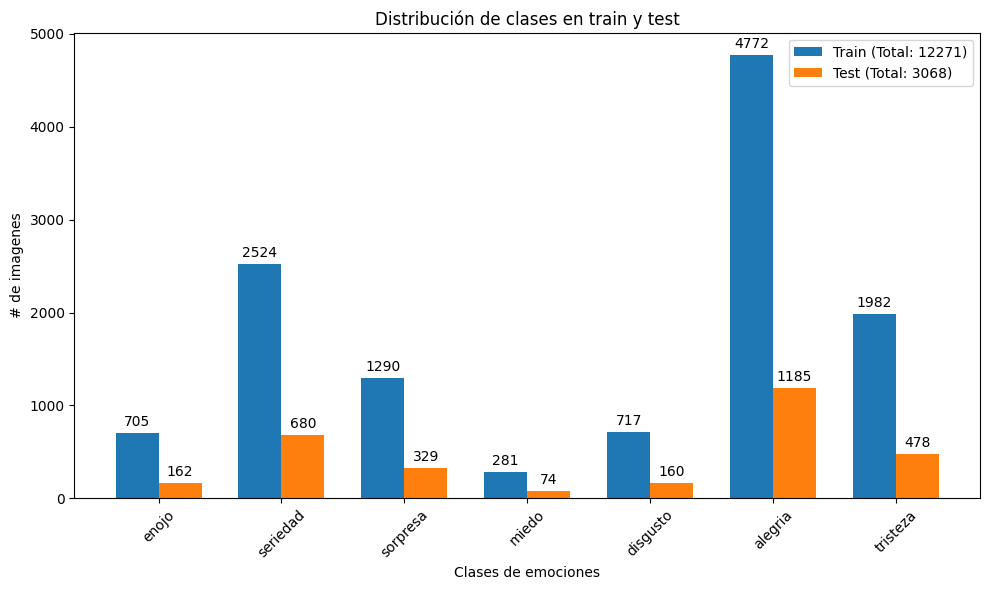

In [77]:
plot_class_distribution(train_counts, test_counts)

Se observa un desbalanceo considerable en las clases para ambos splits (train, test). Se pueden aplicar transformaciones con torch.vision para balancear aplicando rotaciones, cambios de escala, transformaciones en escalas de grises o colores, etc. Vemos que alegría es la mas desbalanceada positivamente en ambos dataset y miedo la que menos frecuencia tiene, se entiende que esto puede explicarse ya que las personas activamente propoician fotos cuando estan alegres y las evitan en el otro extremo.

In [78]:
# Para evitar data leakage obtengo mean y std de train dataset nada mas
train_mean, train_std = mean_std_dataset(dataset_path + "/train")
# mean_std_dataset(dataset_path + "/test")

Calculando media...


100%|██████████| 96/96 [00:04<00:00, 21.15it/s]


Calculando desviación estándar...


100%|██████████| 96/96 [00:05<00:00, 18.23it/s]

Media por canal: tensor([0.5752, 0.4495, 0.4012])
Desviación estándar por canal: tensor([0.2652, 0.2422, 0.2407])


In [79]:
# Cargamos train y test con los todos los canales para inspección visual inicial
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)

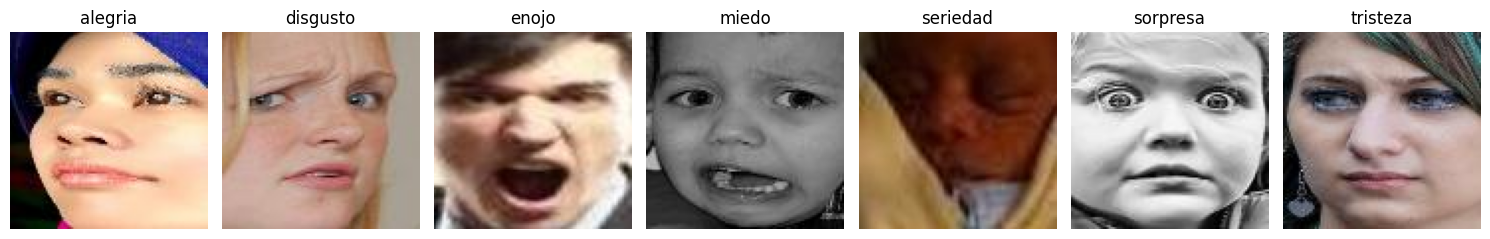

In [80]:
show_first_images_per_class(train_dataset, train_dataset.classes, train_mean, train_std)

### Transformaciones y DataLoaders

Como se dijo anteriormente. ~12k imagenes para 7 clases y con el desbalance observado parece poco para entrenar una red neuronal para esta tarea. Se realizara data augmentation con transformaciones. De esta manera atacaremos 3 frentes:
- Disminuir desbalance de clases
- Aumentar la cantidad de datos para mejorar la performance de la red neuronal en la tarea de clasificación
- Hacer al modelo a entrenar mas robustos a las transfromaciones aplicadas (por ejemplo, podra reconocer mejor emociones de caras rotadas si hacemos augmentation con transformaciones de rotación)

In [81]:
# 1- Se aplican distintas transformaciones para el dataset de train y test
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(100, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=test_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
train_targets = [label for _, label in train_dataset]

# Dividir el dataset en train y validation usando train_test_split
train_indices, val_indices = train_test_split(
    range(len(train_targets)),
    test_size=0.3,
    stratify=train_targets,
    random_state=42
)

# Crear los datasets a partir de los índices
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# 4- Se utiliza data augmentation con WeightedRandomSampler para balancear el dataset
# Obtener las etiquetas del subset de entrenamiento
targets = [train_dataset[i][1] for i in train_indices]

# Calcular pesos por clase
class_counts = Counter(targets)
train_num_samples = len(targets)
val_num_samples = len(val_subset)
class_weights = {cls: train_num_samples / count for cls, count in class_counts.items()}

# Crear los pesos por muestra
sample_weights = [class_weights[label] for label in targets]
sample_weights = torch.DoubleTensor(sample_weights)

# Usar WeightedRandomSampler para balancear el dataset
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=DATASET_AUGMENTED_SIZE,
                                replacement=True)

# 5- Se crean los DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, num_workers=WORKERS, sampler=sampler, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {train_num_samples}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {val_num_samples}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {1: 17.109561752988046, 4: 4.860780984719864, 6: 6.192501802451334, 0: 2.571556886227545, 3: 43.598984771573605, 2: 17.421906693711968, 5: 9.511627906976743}
Tamaño de train dataset original: 8589
Tamaño de train dataset con augmentation: 30000
Tamaño de validation dataset: 3682
Tamaño de test dataset: 3068


Se divide **train** en train / validacion para poder evaluar los distintos modelos a entrenar. Test se lo separa para la evaluación final (ver que tan bien generalizan). Test no recibe ningun tipo de transformación mas allá de las necesarias para el entrenamiento (determinísticas).

Se aplica GreyScale ya que se entiende que el colo no aporta información significativa a la hora de clasificar emociones. Por otro lado, esto permite ganar en performance, ya que al pasar de 3 a 1 canal se reduce dimensionalidad y, por lo tanto, la cantidad de parámetros a entrenar y el tamaño de la red a la hora de hacer inferencia.

Se utiliza **WeightedRandomSampler** como sampler para el DataLoader de train, para poder realizar data augmentation (para tener más datos para la tarea de entrenamiento) asi como suplir el desbalance de clases. Esto se logra, como se explica en los comentarios del código, generando una cantidad muestras de manera inversamente proporcional a la presencia de cada clase. 

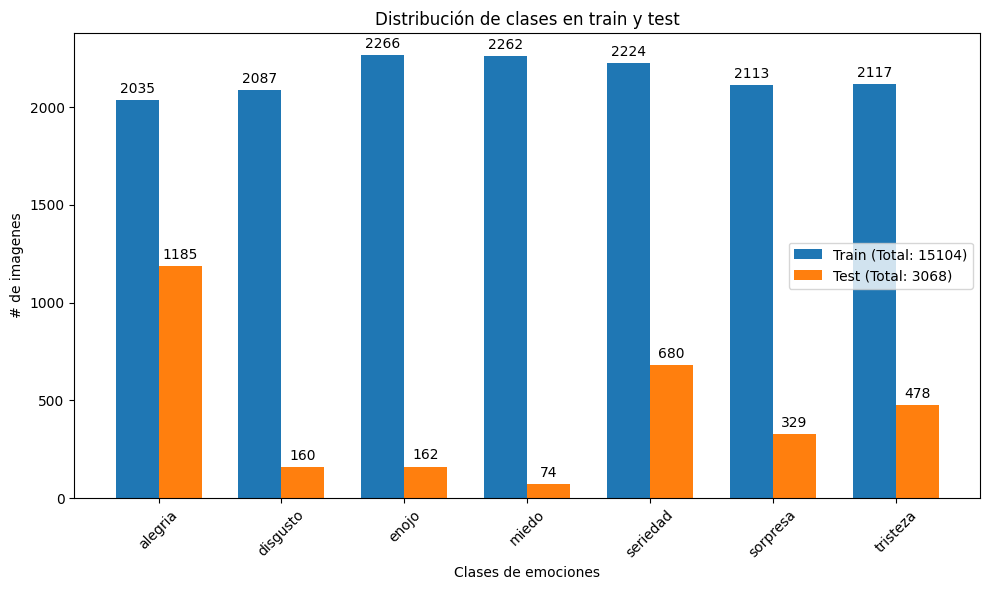

In [82]:
# Probamos el DataLoader y WeightedRandomSampler para ver balanceo de clases
sampled_labels = []
for i, (_, labels) in enumerate(train_loader):
    sampled_labels.extend(labels.numpy())
    if len(sampled_labels) >= DATASET_AUGMENTED_SIZE / 2:  # tomamos una muestra
        break

# Contamos cuántas veces aparece cada clase
balanced_train_counts = Counter(sampled_labels)

train_counts_named = map_counts_to_classnames(balanced_train_counts, train_dataset.classes)
test_counts_named = map_counts_to_classnames(Counter(test_dataset.targets), test_dataset.classes)

plot_class_distribution(train_counts_named, test_counts_named)

Podemos visualizar como se balancean las clases al graficar los datos generados por el dataloader de train.

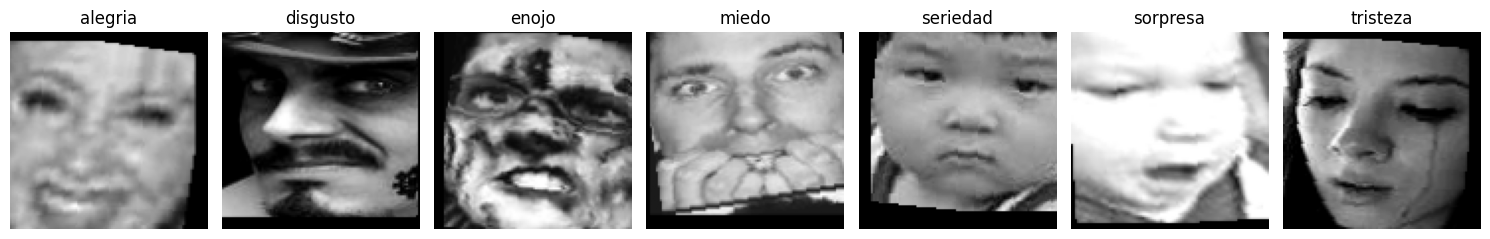

In [83]:
show_first_images_per_class_from_loader(train_loader, train_dataset.classes, [0.5], [0.5], cmap='grey')

Las imagenes se ven en escala de gris y con algunas alteraciones ya que se están graficando luego de aplicar las transformaciones sobre el dataset de train.

## 2. Construcción y entrenamiento del Modelo CNN

### Consigna

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes.

### Validación DataLoader

In [9]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(train_loader))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")


Tamaño del batch de feature (input / imagen): torch.Size([128, 1, 100, 100])
Tamaño del batch del label (clase / etiqueta): torch.Size([128])


Podemos ver correctamente un torch tensor de 128 (tamaño del batch), 1 canal y 100 x 100 pixeles

### Red Convolucional CNN

#### Bloque de convolución

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling

In [7]:
def conv_block(
    c_in: int, 
    c_out: int, 
    kernel_size: int = 3, 
    padding: str = 'same', 
    stride: int = 1, 
    pooling_kernel_size:int = 2
    ) -> torch.nn.Sequential:
    """
    Bloque de convolución seguido de activación y max pooling.

    Args:
        c_in (int): Parametros de entrada.
        c_out (int): Parametros de salida. (features o cantidad de kernels)
        kernel_size (int, optional): Tamaño del kernel cuadrado. Defaults to 3.
        padding (str, optional): Padding aplicado en la convolución. Puede ser un entero o 'same'. Defaults to 'same'.
        stride (int, optional): Stride (paso) de la convolución. Defaults to 1.
        pooling_kernel_size (int, optional): Tamaño del kernel de pooling. Defaults to 2.

    Returns:
        _type_: Módulo secuencial con conv → activación → max pooling.
    """
    return torch.nn.Sequential( # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, kernel_size, padding=padding, stride=stride),
        torch.nn.BatchNorm2d(c_out),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=pooling_kernel_size)
    )

- **Conv2d**	Aprende filtros que detectan bordes, curvas, partes faciales, etc.
- **BatchNorm2d**	Estabiliza el aprendizaje y permite usar mayor tasa de aprendizaje
- **ReLU**	Introduce no linealidad (es más efectiva que tanh para este tipo de imágenes)
- **MaxPool2d**	Reduce tamaño espacial (downsampling), mantiene lo importante

#### Early Stopping

Vamos a implementar **Early Stopping** para no perder tiempo en etapa de entrenamiento. 

Este mecanismo utiliza un *patience* param, que es un contador de la cantidad de epocas en la que no obtenemos la mejora esperada en la loss function. Si el val_loss no mejora lo que indicamos y el counter es mayor o igual a patience entonces early stopping se dispara. Sino, val_loss sera mejor (menor) que (self.best_loss - self.min_delta). En donde, *min_delta* la mejora en la loss respecto de la mejor actual que estamos buscando para que tenga sentido continuar con el entrenamiento.

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): Número de épocas sin mejora antes de detener.
            min_delta (float): Mínima mejora para resetear el contador.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### CNN Simple

In [9]:
class CNNSimple(torch.nn.Module):
    """
    Modelo CNN simple para clasificación de imágenes.
    """
    def __init__(self, n_channels: int = 1, n_outputs: int = 7) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_outputs = n_outputs
        self._build_model()

    def _build_model(self) -> None:
        """
        Construye el modelo CNN.

        Returns:
            torch.nn.Sequential: Modelo CNN.
        """
        # Parte convolucional
        self.conv1 = conv_block(self.n_channels, 32)     # imagen en grises: canal de entrada = 1
        self.conv2 = conv_block(32, 64)
        self.conv3 = conv_block(64, 128)
        # Parte fully connected
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 12 * 12, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs)  # 7 clases de emociones
        )
        
        print('Red creada')
        print('arquitectura:')
        print(self)

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)
        
    def forward(self, x) -> torch.Tensor:
        """
        Pasada forward del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        #print('input shape: ', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        y = self.fc(x)
        return y
    
            
cnn_simple = CNNSimple()

Red creada
arquitectura:
CNNSimple(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1

In [13]:
torchinfo.summary(cnn_simple, input_size=(12, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNNSimple                                [12, 7]                   --
├─Sequential: 1-1                        [12, 32, 50, 50]          --
│    └─Conv2d: 2-1                       [12, 32, 100, 100]        320
│    └─BatchNorm2d: 2-2                  [12, 32, 100, 100]        64
│    └─ReLU: 2-3                         [12, 32, 100, 100]        --
│    └─MaxPool2d: 2-4                    [12, 32, 50, 50]          --
├─Sequential: 1-2                        [12, 64, 25, 25]          --
│    └─Conv2d: 2-5                       [12, 64, 50, 50]          18,496
│    └─BatchNorm2d: 2-6                  [12, 64, 50, 50]          128
│    └─ReLU: 2-7                         [12, 64, 50, 50]          --
│    └─MaxPool2d: 2-8                    [12, 64, 25, 25]          --
├─Sequential: 1-3                        [12, 128, 12, 12]         --
│    └─Conv2d: 2-9                       [12, 128, 25, 25]         73,856
│    

#### Función de entrenamiento

A la función de entrenamiento se la integra con la clase de Early Stopping para cortar el proceso de entrenamiento en caso de no encontrar mejoras.

Además, se agregan los parámetros de **model_name** y **results_file** para guardar los pesos del mejor modelo y sus resultados en validacion y train para ser utilizado y analizado en pasos posteriores.

Se agrega, también, el cálculo de F1 score weighted al ser una métrica más robusta para la evaluación.

Se agrega soporte para metodo de regularizacion **weight_decay** en el optimizador a traves de un BOOL param. Esto se utilizará en la ultima variante entrenada.

In [10]:
def fit(
    model: torch.nn.Sequential, 
    train_loader: DataLoader, 
    eval_loader: DataLoader, 
    epochs: int = 5,
    weight_decay: bool = False,
    model_name: str = 'best_model.pth',
    results_file: str = 'train_data.json'
    ) -> tuple:
    """
    Entrena el modelo y evalúa su rendimiento en el conjunto de validación.

    Args:
        model (torch.nn.Sequential): Modelo PyTorch
        train_loader (DataLoader): Dataloader train
        eval_loader (DataLoader): Dataloader de validación
        epochs (int, optional): Epocas a entrenar. Defaults to 5.
    """
    # enviamos el modelo al device
    model.to(device)
    # definimos optimizer y la función de pérdida
    if not weight_decay:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    # preparamos listas para guardar las loss y la acc a lo largo de la epocas
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    epoch_v_f1 = []
    epoch_t_f1 = []
    
    # inicializamos early stopping
    early_stopping = EarlyStopping(patience=12, min_delta=0.001)
    
    # iteramos en las epocas
    for epoch in range(1, epochs+1):
        # ponemos el modelo en train
        model.train()
        # listas de loss y acc de train para esta epoca
        # así despues calculamos la media
        # por que el dataset lo pasamos de a batches
        train_loss, train_acc = [], []
        train_preds = []
        train_targets = []
        
        bar = tqdm(train_loader)
        for batch in bar:
            X, y = batch  # sacamos X e y del batch
            X, y = X.to(device), y.to(device) # lo enviamos al device
            optimizer.zero_grad() # llevamos optimizer a zero
            y_hat = model(X)  # corremos el modelo y vemos su predicción, esto es la pasada forward (ejecuta forward method del modelo)
            loss = criterion(y_hat, y)  # calculamos la pérdida
            loss.backward() # back-propagations
            optimizer.step()  # step del optimizer
            train_loss.append(loss.item()) # vamos guardando la pérdida de este batch, en la perdida de la epoca
            
            preds = torch.argmax(y_hat, axis=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(y.cpu().numpy())
            
            # calculo de la acc
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc) # vamos guardando la acc de este batch, en la acc de la epoca
                        
            # seteamos descriptores en la barra
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # luego de pasar todo el batch, guardamos la perdida y acc media del train
        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))
        # calculo f1 score
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        epoch_t_f1.append(train_f1)

        # ahora viene es test
        bar = tqdm(eval_loader)
        # listas de loss y acc de test para esta epoca
        # así despues calculamos la media
        # por que el dataset lo pasamos de a batches
        # agregamos all_preds y all_targets para guardar las predicciones y targets
        # así después podemos calcular el f1 score
        # y la matriz de confusión
        val_loss, val_acc = [], []
        all_preds = []
        all_targets = []
        
        # ponemos en eval el modelo
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                
                preds = torch.argmax(y_hat, axis=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y.cpu().numpy())
                
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
            # Calcular F1-score
            val_f1 = f1_score(all_targets, all_preds, average='weighted')
            print(f"Epoch {epoch}/{epochs} "
                f"loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} "
                f"acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f} "
                f"train_f1 {train_f1:.5f} val_f1 {val_f1:.5f}")
    
        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))
        epoch_v_f1.append(val_f1)
        
        # Guardamos el mejor modelo
        if epoch == 1 or np.mean(val_loss) < min(epoch_v_loss[:-1]): # -1 para no contar el que acabo de agregar
            print(f"Mejor modelo guardado en la época {epoch} con val_loss {np.mean(val_loss):.5f}")
            torch.save(model.state_dict(), model_name)
            print("Mejor modelo guardado.")
        
        # Mecanismo Early stopping
        early_stopping(np.mean(val_loss))
        if early_stopping.early_stop:
            print("Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.")
            break

    # Guardamos los datos de entrenamiento en JSON
    with open(results_file, 'w') as f:
        json.dump({
            'epoch_t_loss': epoch_t_loss,
            'epoch_v_loss': epoch_v_loss,
            'epoch_t_acc': epoch_t_acc,
            'epoch_v_acc': epoch_v_acc,
            'epoch_t_f1': epoch_t_f1,
            'epoch_v_f1': epoch_v_f1
        }, f, indent=4)
        print("Datos de entrenamiento guardados en train_data.json")
    

    return epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc, epoch_t_f1, epoch_v_f1
    

#### CNN (Dropout) + CONV x4

In [13]:
class CNN(torch.nn.Module):
    """
    Modelo CNN para clasificación de imágenes.
    """
    def __init__(self, n_channels: int = 1, n_outputs: int = 7) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_outputs = n_outputs
        self._build_model()

    def _build_model(self) -> None:
        """
        Construye el modelo CNN.

        Returns:
            torch.nn.Sequential: Modelo CNN.
        """
        # Parte convolucional
        self.conv1 = conv_block(self.n_channels, 32)     # imagen en grises: canal de entrada = 1
        self.conv2 = conv_block(32, 64)
        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 256)
        # Parte fully connected
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 6 * 6, 512), # se va a 6x6 por el maxpooling aplicado en 4 capas imagen de entrada 100x100
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(512, 256), # se aumenta la cantidad de neuronas para que el dropout no afecte tanto
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),            
            torch.nn.Linear(256, self.n_outputs)  # 7 clases de emociones
        )
        
        print('Red creada')
        print('arquitectura:')
        print(self)

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)
        
    def forward(self, x) -> torch.Tensor:
        """
        Pasada forward del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        #print('input shape: ', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        y = self.fc(x)
        return y
    
            
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3

In [12]:
torchinfo.summary(model, input_size=(1, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 32, 50, 50]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 100]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 100, 100]         64
│    └─ReLU: 2-3                         [1, 32, 100, 100]         --
│    └─MaxPool2d: 2-4                    [1, 32, 50, 50]           --
├─Sequential: 1-2                        [1, 64, 25, 25]           --
│    └─Conv2d: 2-5                       [1, 64, 50, 50]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 50, 50]           128
│    └─ReLU: 2-7                         [1, 64, 50, 50]           --
│    └─MaxPool2d: 2-8                    [1, 64, 25, 25]           --
├─Sequential: 1-3                        [1, 128, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 128, 25, 25]          73,856
│    

Para esta segunda red agregamos dropout (regularización) para ver si podemos evitar el overfitting y vamos a agregar mas complejidad agregando una capa convolucional más.

#### CNN (dropout + weight decay) + CONV x5

In [14]:
class CNNFinal(torch.nn.Module):
    """
    Modelo CNN para clasificación de imágenes.
    """
    def __init__(self, n_channels: int = 1, n_outputs: int = 7) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_outputs = n_outputs
        self._build_model()

    def _build_model(self) -> None:
        """
        Construye el modelo CNN.

        Returns:
            torch.nn.Sequential: Modelo CNN.
        """
        # Parte convolucional
        self.conv1 = conv_block(self.n_channels, 32)     # imagen en grises: canal de entrada = 1
        self.conv2 = conv_block(32, 64)
        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 256)
        self.conv5 = conv_block(256, 512)
        self.dropout = torch.nn.Dropout2d(p=0.15) # Apagar píxeles aislados rompe coherencia espacial con dropout comun.Se usa dropout2d
        # Parte fully connected
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512 * 3 * 3, 512), # se va a 3x3 por el maxpooling aplicado en 5 capas imagen de entrada 100x100
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.4),
            torch.nn.Linear(512, 256), # se aumenta la cantidad de neuronas para que el dropout no afecte tanto
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),            
            torch.nn.Linear(256, self.n_outputs)  # 7 clases de emociones
        )
        
        print('Red creada')
        print('arquitectura:')
        print(self)

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)
        
    def forward(self, x) -> torch.Tensor:
        """
        Pasada forward del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        #print('input shape: ', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(self.conv3(x))
        x = self.dropout(self.conv4(x))
        x = self.dropout(self.conv5(x))
        y = self.fc(x)
        return y
    
            
model_final = CNNFinal()

Red creada
arquitectura:
CNNFinal(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [21]:
torchinfo.summary(model_final, input_size=(1, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNNFinal                                 [1, 7]                    --
├─Sequential: 1-1                        [1, 32, 50, 50]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 100]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 100, 100]         64
│    └─ReLU: 2-3                         [1, 32, 100, 100]         --
│    └─MaxPool2d: 2-4                    [1, 32, 50, 50]           --
├─Sequential: 1-2                        [1, 64, 25, 25]           --
│    └─Conv2d: 2-5                       [1, 64, 50, 50]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 50, 50]           128
│    └─ReLU: 2-7                         [1, 64, 50, 50]           --
│    └─MaxPool2d: 2-8                    [1, 64, 25, 25]           --
├─Sequential: 1-3                        [1, 128, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 128, 25, 25]          73,856
│    

#### Entrenamiento

Desacoplamos los plots de entrenamiento para poder cambiar la estetica sin reentrenar. Además, persistimos esa información en un JSON file y tambien guardamos el mejor modelo (entre todas las epocas) para utilizar luego.

In [69]:
# Entrenamos CNN Simple
fit(cnn_simple, train_loader=train_loader, eval_loader=val_loader, epochs=30, model_name='cnn_simple.pth', results_file='cnn_simple_train_data.json')   

val_loss 1.27199 val_acc 0.52994: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch 1/30 loss 1.47864 val_loss 1.27199 acc 0.45842 val_acc 0.52994 train_f1 0.45584 val_f1 0.55732
Mejor modelo guardado en la época 1 con val_loss 1.27199
Mejor modelo guardado.


val_loss 1.49231 val_acc 0.44813: 100%|██████████| 29/29 [00:01<00:00, 19.74it/s]


Epoch 2/30 loss 1.06462 val_loss 1.49231 acc 0.60168 val_acc 0.44813 train_f1 0.60082 val_f1 0.48707


val_loss 0.94832 val_acc 0.66633: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 3/30 loss 0.95530 val_loss 0.94832 acc 0.64821 val_acc 0.66633 train_f1 0.64824 val_f1 0.67389
Mejor modelo guardado en la época 3 con val_loss 0.94832
Mejor modelo guardado.


val_loss 1.08510 val_acc 0.61913: 100%|██████████| 29/29 [00:01<00:00, 20.85it/s]


Epoch 4/30 loss 0.89073 val_loss 1.08510 acc 0.67084 val_acc 0.61913 train_f1 0.67121 val_f1 0.64124


val_loss 0.89167 val_acc 0.68134: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 5/30 loss 0.83670 val_loss 0.89167 acc 0.69222 val_acc 0.68134 train_f1 0.69260 val_f1 0.68842
Mejor modelo guardado en la época 5 con val_loss 0.89167
Mejor modelo guardado.


val_loss 0.91937 val_acc 0.67425: 100%|██████████| 29/29 [00:01<00:00, 19.23it/s]


Epoch 6/30 loss 0.79187 val_loss 0.91937 acc 0.70898 val_acc 0.67425 train_f1 0.70958 val_f1 0.68264


val_loss 0.98292 val_acc 0.65637: 100%|██████████| 29/29 [00:01<00:00, 18.91it/s]


Epoch 7/30 loss 0.72960 val_loss 0.98292 acc 0.73271 val_acc 0.65637 train_f1 0.73292 val_f1 0.67304


val_loss 1.18288 val_acc 0.59866: 100%|██████████| 29/29 [00:01<00:00, 19.53it/s]


Epoch 8/30 loss 0.70583 val_loss 1.18288 acc 0.74290 val_acc 0.59866 train_f1 0.74311 val_f1 0.63027


val_loss 0.87394 val_acc 0.69814: 100%|██████████| 29/29 [00:01<00:00, 19.44it/s]


Epoch 9/30 loss 0.68101 val_loss 0.87394 acc 0.75062 val_acc 0.69814 train_f1 0.75080 val_f1 0.70405
Mejor modelo guardado en la época 9 con val_loss 0.87394
Mejor modelo guardado.


val_loss 0.90554 val_acc 0.67570: 100%|██████████| 29/29 [00:01<00:00, 19.18it/s]


Epoch 10/30 loss 0.65217 val_loss 0.90554 acc 0.76148 val_acc 0.67570 train_f1 0.76173 val_f1 0.69351


val_loss 0.85639 val_acc 0.70111: 100%|██████████| 29/29 [00:01<00:00, 19.05it/s]


Epoch 11/30 loss 0.62266 val_loss 0.85639 acc 0.77154 val_acc 0.70111 train_f1 0.77174 val_f1 0.70954
Mejor modelo guardado en la época 11 con val_loss 0.85639
Mejor modelo guardado.


val_loss 0.97872 val_acc 0.66571: 100%|██████████| 29/29 [00:01<00:00, 20.04it/s]


Epoch 12/30 loss 0.59643 val_loss 0.97872 acc 0.78293 val_acc 0.66571 train_f1 0.78312 val_f1 0.67846


val_loss 0.84242 val_acc 0.71006: 100%|██████████| 29/29 [00:01<00:00, 19.57it/s]


Epoch 13/30 loss 0.57693 val_loss 0.84242 acc 0.78970 val_acc 0.71006 train_f1 0.78982 val_f1 0.70974
Mejor modelo guardado en la época 13 con val_loss 0.84242
Mejor modelo guardado.


val_loss 0.80569 val_acc 0.70747: 100%|██████████| 29/29 [00:01<00:00, 18.85it/s]


Epoch 14/30 loss 0.55004 val_loss 0.80569 acc 0.79801 val_acc 0.70747 train_f1 0.79819 val_f1 0.71139
Mejor modelo guardado en la época 14 con val_loss 0.80569
Mejor modelo guardado.


val_loss 0.90426 val_acc 0.68739: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch 15/30 loss 0.52900 val_loss 0.90426 acc 0.80732 val_acc 0.68739 train_f1 0.80745 val_f1 0.70038


val_loss 0.93000 val_acc 0.69787: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch 16/30 loss 0.51742 val_loss 0.93000 acc 0.81110 val_acc 0.69787 train_f1 0.81111 val_f1 0.70670


val_loss 0.83003 val_acc 0.73198: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch 17/30 loss 0.49703 val_loss 0.83003 acc 0.82056 val_acc 0.73198 train_f1 0.82062 val_f1 0.73553


val_loss 0.84292 val_acc 0.71565: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


Epoch 18/30 loss 0.48268 val_loss 0.84292 acc 0.82281 val_acc 0.71565 train_f1 0.82287 val_f1 0.72436


val_loss 0.86169 val_acc 0.70991: 100%|██████████| 29/29 [00:01<00:00, 15.49it/s]


Epoch 19/30 loss 0.47191 val_loss 0.86169 acc 0.82772 val_acc 0.70991 train_f1 0.82785 val_f1 0.71991


val_loss 0.80903 val_acc 0.73834: 100%|██████████| 29/29 [00:02<00:00, 12.90it/s]


Epoch 20/30 loss 0.45782 val_loss 0.80903 acc 0.83362 val_acc 0.73834 train_f1 0.83364 val_f1 0.74167


val_loss 0.85147 val_acc 0.72071: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 21/30 loss 0.43513 val_loss 0.85147 acc 0.84247 val_acc 0.72071 train_f1 0.84258 val_f1 0.72535


val_loss 0.90762 val_acc 0.71638: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch 22/30 loss 0.43697 val_loss 0.90762 acc 0.84115 val_acc 0.71638 train_f1 0.84117 val_f1 0.72133


val_loss 0.87010 val_acc 0.72351: 100%|██████████| 29/29 [00:02<00:00, 14.46it/s]


Epoch 23/30 loss 0.42070 val_loss 0.87010 acc 0.84652 val_acc 0.72351 train_f1 0.84658 val_f1 0.73142


val_loss 0.84744 val_acc 0.73043: 100%|██████████| 29/29 [00:02<00:00, 13.92it/s]


Epoch 24/30 loss 0.40409 val_loss 0.84744 acc 0.85469 val_acc 0.73043 train_f1 0.85480 val_f1 0.73369


val_loss 0.92006 val_acc 0.71253: 100%|██████████| 29/29 [00:01<00:00, 16.16it/s]


Epoch 25/30 loss 0.39639 val_loss 0.92006 acc 0.85575 val_acc 0.71253 train_f1 0.85578 val_f1 0.72443


val_loss 0.85864 val_acc 0.73260: 100%|██████████| 29/29 [00:01<00:00, 15.85it/s]

Epoch 26/30 loss 0.39075 val_loss 0.85864 acc 0.85979 val_acc 0.73260 train_f1 0.85978 val_f1 0.73739
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(1.4786370828023652),
  np.float64(1.0646230837573176),
  np.float64(0.9553030380202682),
  np.float64(0.8907332283151729),
  np.float64(0.8367010519632598),
  np.float64(0.7918686868284669),
  np.float64(0.7296048657363637),
  np.float64(0.7058324444172023),
  np.float64(0.6810093352861721),
  np.float64(0.652170044077022),
  np.float64(0.6226588761257699),
  np.float64(0.5964260137142123),
  np.float64(0.5769279232567839),
  np.float64(0.5500374260308493),
  np.float64(0.5289952630734505),
  np.float64(0.5174237949311581),
  np.float64(0.497033974856062),
  np.float64(0.48268149758848694),
  np.float64(0.4719103913935249),
  np.float64(0.45782427211551713),
  np.float64(0.4351277341470694),
  np.float64(0.43696831810809766),
  np.float64(0.42069584855338193),
  np.float64(0.4040914977831609),
  np.float64(0.39639486040910493),
  np.float64(0.39074798698163093)],
 [np.float64(1.2719942495740693),
  np.float64(1.4923056528486054),
  np.float64(0.9483173448463966),
  np.floa

Se observa a partir de la epoca ~10 aproximadamente que, mientras que loss en train baja de manera suave, loss en validación empieza a subir. Lo mismo sucede con Accuracy, donde a partir de esa misma epoca val accuracy pierde su pendiente positiva. 

Debido a estos resultados es que se procede a implementar un modelo con mas complejidad y, además, se implementara regularización y early stoppping para que la busqueda de epocas no sea un proceso manual.

No obstante a los resultados mencionados anteriormente, los resultados finales de este modelo fueron:

**Epoch 30/30:**  
| Metric       | Train       | Validation  |
|--------------|-------------|-------------|
| Accuracy     | **0.81747** | **0.70884** |
| Loss         | **0.51458** | **0.85754** |

Resumiendo, se implementará:
- Dropout
- Early Stopping
- Mayor complejidad de modelo
- Mayor data augmentation
- Se agregará F1 weighted score para mayor robustez en evaluación
- Se agregará tiempo de entrenamiento como métrica de evaluación final del modelo




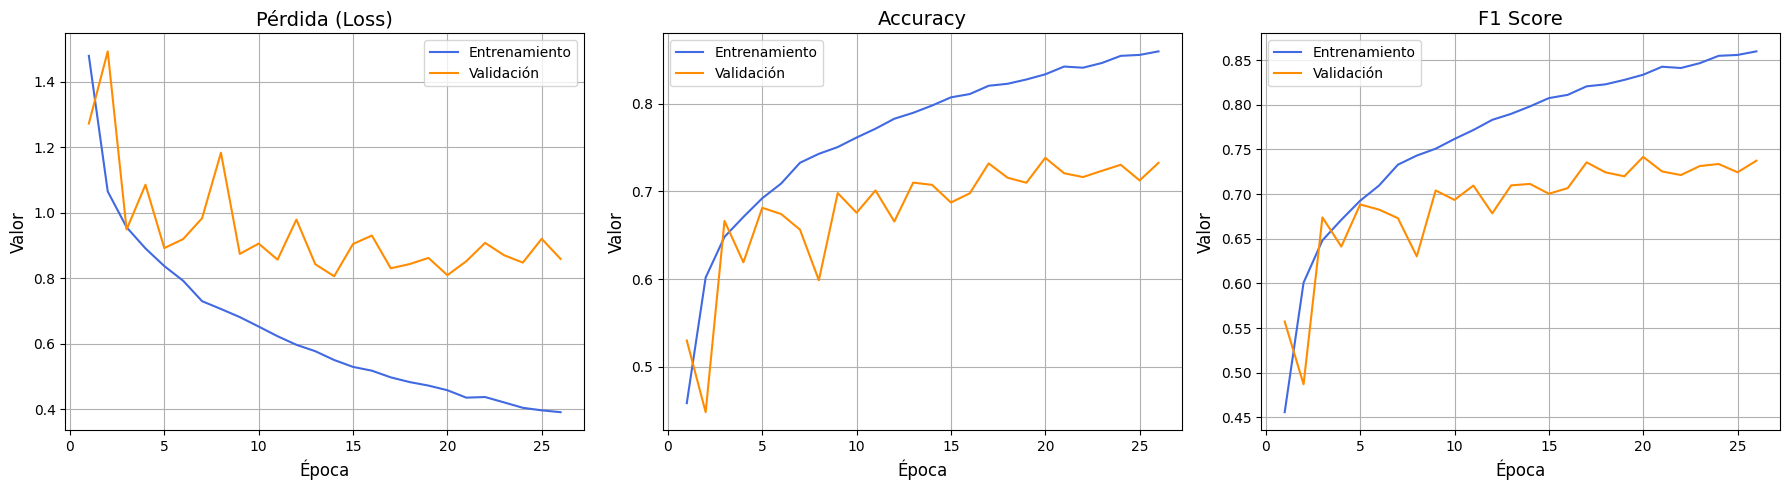

In [22]:
plot_train_results_from_json(json_file='cnn_simple_train_data.json')

In [17]:
fit(model=model, train_loader=train_loader, eval_loader=val_loader, epochs=80, model_name='cnn.pth', results_file='cnn_train_data.json')

val_loss 2.00874 val_acc 0.22887: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch 1/80 loss 1.90676 val_loss 2.00874 acc 0.21289 val_acc 0.22887 train_f1 0.20942 val_f1 0.23301
Mejor modelo guardado en la época 1 con val_loss 2.00874
Mejor modelo guardado.


val_loss 1.69018 val_acc 0.40344: 100%|██████████| 29/29 [00:01<00:00, 20.53it/s]


Epoch 2/80 loss 1.77597 val_loss 1.69018 acc 0.26863 val_acc 0.40344 train_f1 0.25783 val_f1 0.37823
Mejor modelo guardado en la época 2 con val_loss 1.69018
Mejor modelo guardado.


val_loss 1.51573 val_acc 0.45524: 100%|██████████| 29/29 [00:01<00:00, 22.20it/s]


Epoch 3/80 loss 1.63095 val_loss 1.51573 acc 0.35677 val_acc 0.45524 train_f1 0.34863 val_f1 0.44607
Mejor modelo guardado en la época 3 con val_loss 1.51573
Mejor modelo guardado.


val_loss 1.44211 val_acc 0.47273: 100%|██████████| 29/29 [00:01<00:00, 19.60it/s]


Epoch 4/80 loss 1.45374 val_loss 1.44211 acc 0.44110 val_acc 0.47273 train_f1 0.43683 val_f1 0.48231
Mejor modelo guardado en la época 4 con val_loss 1.44211
Mejor modelo guardado.


val_loss 1.22753 val_acc 0.58937: 100%|██████████| 29/29 [00:01<00:00, 19.63it/s]


Epoch 5/80 loss 1.30036 val_loss 1.22753 acc 0.50721 val_acc 0.58937 train_f1 0.50515 val_f1 0.61537
Mejor modelo guardado en la época 5 con val_loss 1.22753
Mejor modelo guardado.


val_loss 1.24912 val_acc 0.54204: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 6/80 loss 1.20009 val_loss 1.24912 acc 0.54455 val_acc 0.54204 train_f1 0.54312 val_f1 0.56041


val_loss 1.11417 val_acc 0.61818: 100%|██████████| 29/29 [00:01<00:00, 17.23it/s]


Epoch 7/80 loss 1.11385 val_loss 1.11417 acc 0.58228 val_acc 0.61818 train_f1 0.58179 val_f1 0.63969
Mejor modelo guardado en la época 7 con val_loss 1.11417
Mejor modelo guardado.


val_loss 1.13121 val_acc 0.59917: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch 8/80 loss 1.04541 val_loss 1.13121 acc 0.60472 val_acc 0.59917 train_f1 0.60472 val_f1 0.63404


val_loss 0.95739 val_acc 0.67172: 100%|██████████| 29/29 [00:01<00:00, 15.91it/s]


Epoch 9/80 loss 0.98565 val_loss 0.95739 acc 0.63536 val_acc 0.67172 train_f1 0.63661 val_f1 0.67701
Mejor modelo guardado en la época 9 con val_loss 0.95739
Mejor modelo guardado.


val_loss 0.97040 val_acc 0.66523: 100%|██████████| 29/29 [00:01<00:00, 16.06it/s]


Epoch 10/80 loss 0.91483 val_loss 0.97040 acc 0.66430 val_acc 0.66523 train_f1 0.66495 val_f1 0.68027


val_loss 0.92105 val_acc 0.67694: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch 11/80 loss 0.87460 val_loss 0.92105 acc 0.67595 val_acc 0.67694 train_f1 0.67725 val_f1 0.69088
Mejor modelo guardado en la época 11 con val_loss 0.92105
Mejor modelo guardado.


val_loss 0.89610 val_acc 0.69122: 100%|██████████| 29/29 [00:01<00:00, 16.12it/s]


Epoch 12/80 loss 0.82757 val_loss 0.89610 acc 0.69787 val_acc 0.69122 train_f1 0.69926 val_f1 0.70488
Mejor modelo guardado en la época 12 con val_loss 0.89610
Mejor modelo guardado.


val_loss 0.87167 val_acc 0.71111: 100%|██████████| 29/29 [00:01<00:00, 15.41it/s]


Epoch 13/80 loss 0.79510 val_loss 0.87167 acc 0.70785 val_acc 0.71111 train_f1 0.70974 val_f1 0.72015
Mejor modelo guardado en la época 13 con val_loss 0.87167
Mejor modelo guardado.


val_loss 0.90417 val_acc 0.67910: 100%|██████████| 29/29 [00:01<00:00, 16.29it/s]


Epoch 14/80 loss 0.75935 val_loss 0.90417 acc 0.72118 val_acc 0.67910 train_f1 0.72254 val_f1 0.69553


val_loss 0.81020 val_acc 0.72647: 100%|██████████| 29/29 [00:01<00:00, 16.22it/s]


Epoch 15/80 loss 0.72934 val_loss 0.81020 acc 0.73238 val_acc 0.72647 train_f1 0.73377 val_f1 0.73479
Mejor modelo guardado en la época 15 con val_loss 0.81020
Mejor modelo guardado.


val_loss 0.88034 val_acc 0.70415: 100%|██████████| 29/29 [00:01<00:00, 16.20it/s]


Epoch 16/80 loss 0.68486 val_loss 0.88034 acc 0.74864 val_acc 0.70415 train_f1 0.75020 val_f1 0.71812


val_loss 0.77669 val_acc 0.72954: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


Epoch 17/80 loss 0.65759 val_loss 0.77669 acc 0.76229 val_acc 0.72954 train_f1 0.76342 val_f1 0.73325
Mejor modelo guardado en la época 17 con val_loss 0.77669
Mejor modelo guardado.


val_loss 0.78669 val_acc 0.71766: 100%|██████████| 29/29 [00:01<00:00, 16.51it/s]


Epoch 18/80 loss 0.62844 val_loss 0.78669 acc 0.77427 val_acc 0.71766 train_f1 0.77540 val_f1 0.73404


val_loss 0.82773 val_acc 0.71791: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch 19/80 loss 0.61781 val_loss 0.82773 acc 0.77590 val_acc 0.71791 train_f1 0.77737 val_f1 0.73492


val_loss 0.77579 val_acc 0.73770: 100%|██████████| 29/29 [00:01<00:00, 16.52it/s]


Epoch 20/80 loss 0.59013 val_loss 0.77579 acc 0.78729 val_acc 0.73770 train_f1 0.78794 val_f1 0.74358
Mejor modelo guardado en la época 20 con val_loss 0.77579
Mejor modelo guardado.


val_loss 0.78233 val_acc 0.72496: 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 21/80 loss 0.57248 val_loss 0.78233 acc 0.79127 val_acc 0.72496 train_f1 0.79196 val_f1 0.73810


val_loss 0.76225 val_acc 0.72086: 100%|██████████| 29/29 [00:01<00:00, 16.77it/s]


Epoch 22/80 loss 0.54364 val_loss 0.76225 acc 0.80512 val_acc 0.72086 train_f1 0.80590 val_f1 0.73663
Mejor modelo guardado en la época 22 con val_loss 0.76225
Mejor modelo guardado.


val_loss 0.85793 val_acc 0.69288: 100%|██████████| 29/29 [00:01<00:00, 16.81it/s]


Epoch 23/80 loss 0.52315 val_loss 0.85793 acc 0.81199 val_acc 0.69288 train_f1 0.81272 val_f1 0.70833


val_loss 0.74318 val_acc 0.73468: 100%|██████████| 29/29 [00:01<00:00, 16.69it/s]


Epoch 24/80 loss 0.50429 val_loss 0.74318 acc 0.81869 val_acc 0.73468 train_f1 0.81936 val_f1 0.74556
Mejor modelo guardado en la época 24 con val_loss 0.74318
Mejor modelo guardado.


val_loss 0.76924 val_acc 0.73304: 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]


Epoch 25/80 loss 0.49658 val_loss 0.76924 acc 0.82438 val_acc 0.73304 train_f1 0.82520 val_f1 0.74723


val_loss 0.77336 val_acc 0.71323: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


Epoch 26/80 loss 0.48003 val_loss 0.77336 acc 0.82927 val_acc 0.71323 train_f1 0.83012 val_f1 0.72297


val_loss 0.76544 val_acc 0.72376: 100%|██████████| 29/29 [00:01<00:00, 15.79it/s]


Epoch 27/80 loss 0.46239 val_loss 0.76544 acc 0.83312 val_acc 0.72376 train_f1 0.83389 val_f1 0.73958


val_loss 0.77261 val_acc 0.72678: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


Epoch 28/80 loss 0.44979 val_loss 0.77261 acc 0.83861 val_acc 0.72678 train_f1 0.83955 val_f1 0.74001


val_loss 0.70822 val_acc 0.76025: 100%|██████████| 29/29 [00:01<00:00, 16.49it/s]


Epoch 29/80 loss 0.42394 val_loss 0.70822 acc 0.85185 val_acc 0.76025 train_f1 0.85243 val_f1 0.76648
Mejor modelo guardado en la época 29 con val_loss 0.70822
Mejor modelo guardado.


val_loss 0.72358 val_acc 0.73872: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch 30/80 loss 0.42117 val_loss 0.72358 acc 0.85146 val_acc 0.73872 train_f1 0.85165 val_f1 0.75226


val_loss 0.69952 val_acc 0.76790: 100%|██████████| 29/29 [00:01<00:00, 16.17it/s]


Epoch 31/80 loss 0.41876 val_loss 0.69952 acc 0.85157 val_acc 0.76790 train_f1 0.85209 val_f1 0.77348
Mejor modelo guardado en la época 31 con val_loss 0.69952
Mejor modelo guardado.


val_loss 0.75178 val_acc 0.73646: 100%|██████████| 29/29 [00:01<00:00, 16.90it/s]


Epoch 32/80 loss 0.39742 val_loss 0.75178 acc 0.85781 val_acc 0.73646 train_f1 0.85823 val_f1 0.74592


val_loss 0.70448 val_acc 0.75718: 100%|██████████| 29/29 [00:01<00:00, 16.09it/s]


Epoch 33/80 loss 0.39079 val_loss 0.70448 acc 0.86231 val_acc 0.75718 train_f1 0.86279 val_f1 0.76099


val_loss 0.74911 val_acc 0.73368: 100%|██████████| 29/29 [00:01<00:00, 16.54it/s]


Epoch 34/80 loss 0.38023 val_loss 0.74911 acc 0.86442 val_acc 0.73368 train_f1 0.86472 val_f1 0.74738


val_loss 0.73134 val_acc 0.75214: 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]


Epoch 35/80 loss 0.37034 val_loss 0.73134 acc 0.86903 val_acc 0.75214 train_f1 0.86930 val_f1 0.75638


val_loss 0.68373 val_acc 0.77768: 100%|██████████| 29/29 [00:01<00:00, 16.46it/s]


Epoch 36/80 loss 0.36748 val_loss 0.68373 acc 0.87105 val_acc 0.77768 train_f1 0.87129 val_f1 0.77943
Mejor modelo guardado en la época 36 con val_loss 0.68373
Mejor modelo guardado.


val_loss 0.74487 val_acc 0.72676: 100%|██████████| 29/29 [00:01<00:00, 16.01it/s]


Epoch 37/80 loss 0.35188 val_loss 0.74487 acc 0.87600 val_acc 0.72676 train_f1 0.87619 val_f1 0.73614


val_loss 0.74219 val_acc 0.74268: 100%|██████████| 29/29 [00:01<00:00, 16.39it/s]


Epoch 38/80 loss 0.34326 val_loss 0.74219 acc 0.87870 val_acc 0.74268 train_f1 0.87920 val_f1 0.75305


val_loss 0.68943 val_acc 0.76644: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch 39/80 loss 0.33794 val_loss 0.68943 acc 0.88126 val_acc 0.76644 train_f1 0.88175 val_f1 0.77176


val_loss 0.68961 val_acc 0.75950: 100%|██████████| 29/29 [00:01<00:00, 16.90it/s]


Epoch 40/80 loss 0.31944 val_loss 0.68961 acc 0.88841 val_acc 0.75950 train_f1 0.88858 val_f1 0.76627


val_loss 0.72115 val_acc 0.74815: 100%|██████████| 29/29 [00:02<00:00, 13.04it/s]


Epoch 41/80 loss 0.34102 val_loss 0.72115 acc 0.87929 val_acc 0.74815 train_f1 0.87951 val_f1 0.75051


val_loss 0.73321 val_acc 0.74131: 100%|██████████| 29/29 [00:02<00:00, 12.95it/s]


Epoch 42/80 loss 0.31898 val_loss 0.73321 acc 0.89081 val_acc 0.74131 train_f1 0.89135 val_f1 0.75295


val_loss 0.71465 val_acc 0.75880: 100%|██████████| 29/29 [00:02<00:00, 11.08it/s]


Epoch 43/80 loss 0.31302 val_loss 0.71465 acc 0.89203 val_acc 0.75880 train_f1 0.89276 val_f1 0.76474


val_loss 0.70734 val_acc 0.75550: 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]


Epoch 44/80 loss 0.30930 val_loss 0.70734 acc 0.89128 val_acc 0.75550 train_f1 0.89159 val_f1 0.76610


val_loss 0.70439 val_acc 0.75610: 100%|██████████| 29/29 [00:01<00:00, 19.44it/s]


Epoch 45/80 loss 0.29830 val_loss 0.70439 acc 0.89458 val_acc 0.75610 train_f1 0.89474 val_f1 0.76314


val_loss 0.72316 val_acc 0.74549: 100%|██████████| 29/29 [00:01<00:00, 19.78it/s]


Epoch 46/80 loss 0.28908 val_loss 0.72316 acc 0.89671 val_acc 0.74549 train_f1 0.89705 val_f1 0.75285


val_loss 0.71140 val_acc 0.75368: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 47/80 loss 0.28367 val_loss 0.71140 acc 0.90121 val_acc 0.75368 train_f1 0.90154 val_f1 0.76023


val_loss 0.73339 val_acc 0.75347: 100%|██████████| 29/29 [00:02<00:00, 13.15it/s]


Epoch 48/80 loss 0.28222 val_loss 0.73339 acc 0.90268 val_acc 0.75347 train_f1 0.90280 val_f1 0.75599
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(1.9067595867400473),
  np.float64(1.7759673240336966),
  np.float64(1.6309500039891993),
  np.float64(1.4537377717647146),
  np.float64(1.3003646394039723),
  np.float64(1.2000934189938484),
  np.float64(1.1138502463381341),
  np.float64(1.0454144518426125),
  np.float64(0.9856543338045161),
  np.float64(0.9148344273262835),
  np.float64(0.8746043836816828),
  np.float64(0.8275675309465287),
  np.float64(0.795102344675267),
  np.float64(0.7593486697115797),
  np.float64(0.7293380127308217),
  np.float64(0.6848588376603229),
  np.float64(0.6575906633062566),
  np.float64(0.6284447777778545),
  np.float64(0.6178051736760647),
  np.float64(0.5901343151609948),
  np.float64(0.5724774619366261),
  np.float64(0.5436448995103227),
  np.float64(0.5231492882079266),
  np.float64(0.5042900148858416),
  np.float64(0.49658212623697645),
  np.float64(0.4800306667672827),
  np.float64(0.4623932913262793),
  np.float64(0.44978524161146044),
  np.float64(0.4239356644610141),
  np.float64(

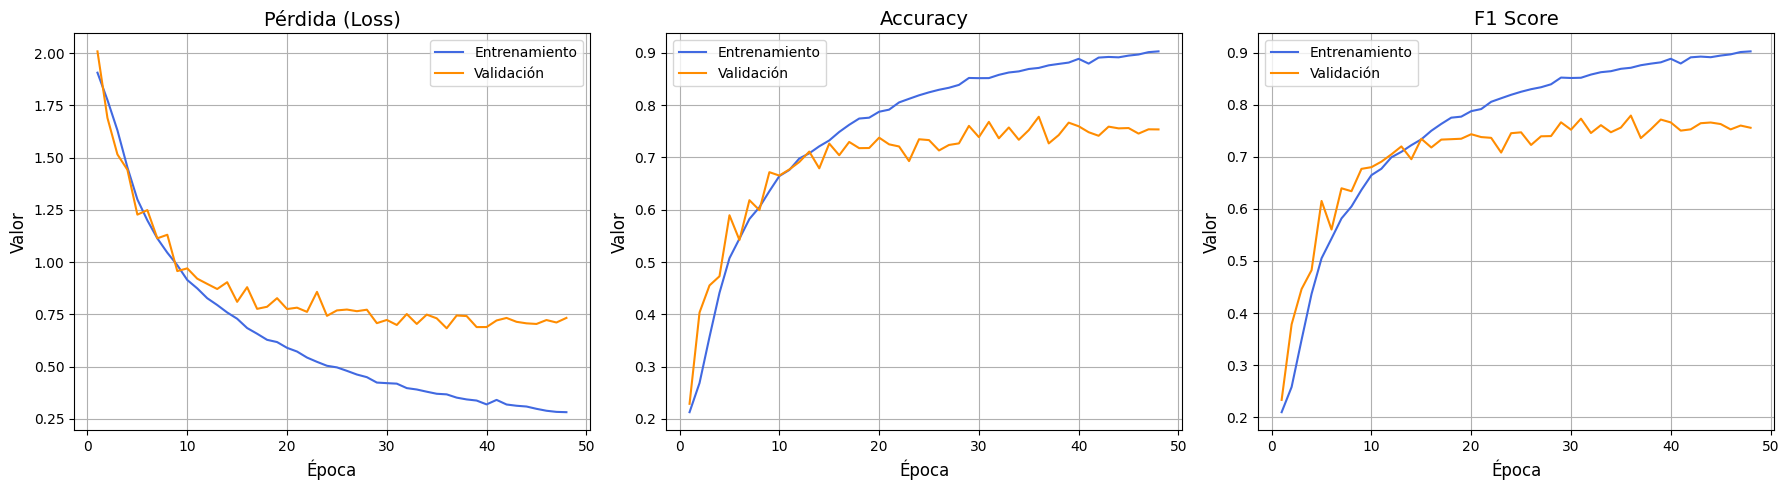

In [18]:
plot_train_results_from_json(json_file='cnn_train_data.json')

In [52]:
fit(model=model_final, train_loader=train_loader, eval_loader=val_loader, epochs=80, weight_decay=True, model_name='cnn_final.pth', results_file='cnn_train_data_final.json')

val_loss 1.79688 val_acc 0.29881: 100%|██████████| 29/29 [00:03<00:00,  7.83it/s]


Epoch 1/80 loss 1.84429 val_loss 1.79688 acc 0.22848 val_acc 0.29881 train_f1 0.22313 val_f1 0.28006
Mejor modelo guardado en la época 1 con val_loss 1.79688
Mejor modelo guardado.


val_loss 1.35687 val_acc 0.51223: 100%|██████████| 29/29 [00:04<00:00,  6.12it/s]


Epoch 2/80 loss 1.62503 val_loss 1.35687 acc 0.35778 val_acc 0.51223 train_f1 0.34502 val_f1 0.49274
Mejor modelo guardado en la época 2 con val_loss 1.35687
Mejor modelo guardado.


val_loss 1.13422 val_acc 0.59140: 100%|██████████| 29/29 [00:06<00:00,  4.47it/s]


Epoch 3/80 loss 1.34542 val_loss 1.13422 acc 0.48922 val_acc 0.59140 train_f1 0.48286 val_f1 0.61482
Mejor modelo guardado en la época 3 con val_loss 1.13422
Mejor modelo guardado.


val_loss 1.09375 val_acc 0.63144: 100%|██████████| 29/29 [00:06<00:00,  4.62it/s]


Epoch 4/80 loss 1.15847 val_loss 1.09375 acc 0.56441 val_acc 0.63144 train_f1 0.56247 val_f1 0.64486
Mejor modelo guardado en la época 4 con val_loss 1.09375
Mejor modelo guardado.


val_loss 1.06481 val_acc 0.61298: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 5/80 loss 1.03442 val_loss 1.06481 acc 0.61623 val_acc 0.61298 train_f1 0.61611 val_f1 0.63912
Mejor modelo guardado en la época 5 con val_loss 1.06481
Mejor modelo guardado.


val_loss 0.89863 val_acc 0.68449: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 6/80 loss 0.94616 val_loss 0.89863 acc 0.64878 val_acc 0.68449 train_f1 0.64877 val_f1 0.69560
Mejor modelo guardado en la época 6 con val_loss 0.89863
Mejor modelo guardado.


val_loss 0.86790 val_acc 0.69236: 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]


Epoch 7/80 loss 0.87960 val_loss 0.86790 acc 0.67794 val_acc 0.69236 train_f1 0.67814 val_f1 0.70696
Mejor modelo guardado en la época 7 con val_loss 0.86790
Mejor modelo guardado.


val_loss 0.99780 val_acc 0.63753: 100%|██████████| 29/29 [00:01<00:00, 15.16it/s]


Epoch 8/80 loss 0.83251 val_loss 0.99780 acc 0.69425 val_acc 0.63753 train_f1 0.69548 val_f1 0.67056


val_loss 0.83842 val_acc 0.70902: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch 9/80 loss 0.78155 val_loss 0.83842 acc 0.71314 val_acc 0.70902 train_f1 0.71357 val_f1 0.71686
Mejor modelo guardado en la época 9 con val_loss 0.83842
Mejor modelo guardado.


val_loss 0.76971 val_acc 0.73358: 100%|██████████| 29/29 [00:01<00:00, 16.72it/s]


Epoch 10/80 loss 0.73237 val_loss 0.76971 acc 0.73542 val_acc 0.73358 train_f1 0.73606 val_f1 0.74314
Mejor modelo guardado en la época 10 con val_loss 0.76971
Mejor modelo guardado.


val_loss 0.81989 val_acc 0.70598: 100%|██████████| 29/29 [00:01<00:00, 15.10it/s]


Epoch 11/80 loss 0.69111 val_loss 0.81989 acc 0.74853 val_acc 0.70598 train_f1 0.74930 val_f1 0.72181


val_loss 0.80840 val_acc 0.70243: 100%|██████████| 29/29 [00:01<00:00, 16.04it/s]


Epoch 12/80 loss 0.65764 val_loss 0.80840 acc 0.76449 val_acc 0.70243 train_f1 0.76539 val_f1 0.72306


val_loss 0.76279 val_acc 0.72375: 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]


Epoch 13/80 loss 0.62552 val_loss 0.76279 acc 0.77380 val_acc 0.72375 train_f1 0.77449 val_f1 0.73724
Mejor modelo guardado en la época 13 con val_loss 0.76279
Mejor modelo guardado.


val_loss 0.73877 val_acc 0.73899: 100%|██████████| 29/29 [00:01<00:00, 15.90it/s]


Epoch 14/80 loss 0.59236 val_loss 0.73877 acc 0.78708 val_acc 0.73899 train_f1 0.78748 val_f1 0.74438
Mejor modelo guardado en la época 14 con val_loss 0.73877
Mejor modelo guardado.


val_loss 0.74915 val_acc 0.73155: 100%|██████████| 29/29 [00:01<00:00, 16.25it/s]


Epoch 15/80 loss 0.56464 val_loss 0.74915 acc 0.79720 val_acc 0.73155 train_f1 0.79812 val_f1 0.74160


val_loss 0.76655 val_acc 0.72546: 100%|██████████| 29/29 [00:18<00:00,  1.53it/s]


Epoch 16/80 loss 0.55100 val_loss 0.76655 acc 0.80120 val_acc 0.72546 train_f1 0.80193 val_f1 0.73955


val_loss 0.73979 val_acc 0.73724: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 17/80 loss 0.51367 val_loss 0.73979 acc 0.81495 val_acc 0.73724 train_f1 0.81560 val_f1 0.75202


val_loss 0.72766 val_acc 0.74875: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 18/80 loss 0.49678 val_loss 0.72766 acc 0.82183 val_acc 0.74875 train_f1 0.82221 val_f1 0.75401
Mejor modelo guardado en la época 18 con val_loss 0.72766
Mejor modelo guardado.


val_loss 0.72900 val_acc 0.75047: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch 19/80 loss 0.47586 val_loss 0.72900 acc 0.83009 val_acc 0.75047 train_f1 0.83061 val_f1 0.75401


val_loss 0.66247 val_acc 0.76742: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 20/80 loss 0.46273 val_loss 0.66247 acc 0.83365 val_acc 0.76742 train_f1 0.83415 val_f1 0.76919
Mejor modelo guardado en la época 20 con val_loss 0.66247
Mejor modelo guardado.


val_loss 0.68942 val_acc 0.75217: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 21/80 loss 0.43501 val_loss 0.68942 acc 0.84449 val_acc 0.75217 train_f1 0.84469 val_f1 0.76205


val_loss 0.69623 val_acc 0.74640: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch 22/80 loss 0.42937 val_loss 0.69623 acc 0.85002 val_acc 0.74640 train_f1 0.85060 val_f1 0.76128


val_loss 0.64841 val_acc 0.77593: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch 23/80 loss 0.41972 val_loss 0.64841 acc 0.85184 val_acc 0.77593 train_f1 0.85208 val_f1 0.78182
Mejor modelo guardado en la época 23 con val_loss 0.64841
Mejor modelo guardado.


val_loss 0.69370 val_acc 0.76041: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch 24/80 loss 0.39530 val_loss 0.69370 acc 0.85914 val_acc 0.76041 train_f1 0.85942 val_f1 0.76929


val_loss 0.68123 val_acc 0.76833: 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]


Epoch 25/80 loss 0.38971 val_loss 0.68123 acc 0.86186 val_acc 0.76833 train_f1 0.86235 val_f1 0.76927


val_loss 0.65790 val_acc 0.77378: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch 26/80 loss 0.37994 val_loss 0.65790 acc 0.86461 val_acc 0.77378 train_f1 0.86498 val_f1 0.77983


val_loss 0.68778 val_acc 0.76130: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch 27/80 loss 0.35778 val_loss 0.68778 acc 0.87234 val_acc 0.76130 train_f1 0.87268 val_f1 0.76873


val_loss 0.74960 val_acc 0.73476: 100%|██████████| 29/29 [00:01<00:00, 17.18it/s]


Epoch 28/80 loss 0.35038 val_loss 0.74960 acc 0.87598 val_acc 0.73476 train_f1 0.87617 val_f1 0.75383


val_loss 0.64071 val_acc 0.78857: 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]


Epoch 29/80 loss 0.33486 val_loss 0.64071 acc 0.88404 val_acc 0.78857 train_f1 0.88432 val_f1 0.79276
Mejor modelo guardado en la época 29 con val_loss 0.64071
Mejor modelo guardado.


val_loss 0.68367 val_acc 0.77042: 100%|██████████| 29/29 [00:01<00:00, 16.81it/s]


Epoch 30/80 loss 0.33346 val_loss 0.68367 acc 0.88330 val_acc 0.77042 train_f1 0.88366 val_f1 0.77590


val_loss 0.70110 val_acc 0.76553: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch 31/80 loss 0.31739 val_loss 0.70110 acc 0.88840 val_acc 0.76553 train_f1 0.88857 val_f1 0.77110


val_loss 0.64898 val_acc 0.77730: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch 32/80 loss 0.31742 val_loss 0.64898 acc 0.88848 val_acc 0.77730 train_f1 0.88834 val_f1 0.78476


val_loss 0.64215 val_acc 0.78541: 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]


Epoch 33/80 loss 0.30013 val_loss 0.64215 acc 0.89268 val_acc 0.78541 train_f1 0.89301 val_f1 0.79067


val_loss 0.70131 val_acc 0.76203: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch 34/80 loss 0.29897 val_loss 0.70131 acc 0.89676 val_acc 0.76203 train_f1 0.89698 val_f1 0.77002


val_loss 0.65055 val_acc 0.79471: 100%|██████████| 29/29 [00:01<00:00, 16.58it/s]


Epoch 35/80 loss 0.28029 val_loss 0.65055 acc 0.90453 val_acc 0.79471 train_f1 0.90457 val_f1 0.79796


val_loss 0.66523 val_acc 0.77299: 100%|██████████| 29/29 [00:01<00:00, 17.09it/s]


Epoch 36/80 loss 0.28340 val_loss 0.66523 acc 0.90139 val_acc 0.77299 train_f1 0.90144 val_f1 0.77947


val_loss 0.68725 val_acc 0.76400: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch 37/80 loss 0.27025 val_loss 0.68725 acc 0.90503 val_acc 0.76400 train_f1 0.90508 val_f1 0.77674


val_loss 0.64633 val_acc 0.78213: 100%|██████████| 29/29 [00:01<00:00, 16.39it/s]


Epoch 38/80 loss 0.27991 val_loss 0.64633 acc 0.90288 val_acc 0.78213 train_f1 0.90316 val_f1 0.78912


val_loss 0.65798 val_acc 0.77884: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch 39/80 loss 0.26252 val_loss 0.65798 acc 0.90904 val_acc 0.77884 train_f1 0.90904 val_f1 0.78780


val_loss 0.66240 val_acc 0.77892: 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]


Epoch 40/80 loss 0.25959 val_loss 0.66240 acc 0.91067 val_acc 0.77892 train_f1 0.91060 val_f1 0.78533


val_loss 0.63951 val_acc 0.78420: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch 41/80 loss 0.25420 val_loss 0.63951 acc 0.91259 val_acc 0.78420 train_f1 0.91267 val_f1 0.78821
Mejor modelo guardado en la época 41 con val_loss 0.63951
Mejor modelo guardado.


val_loss 0.63908 val_acc 0.79450: 100%|██████████| 29/29 [00:01<00:00, 16.56it/s]


Epoch 42/80 loss 0.25453 val_loss 0.63908 acc 0.91139 val_acc 0.79450 train_f1 0.91128 val_f1 0.79825
Mejor modelo guardado en la época 42 con val_loss 0.63908
Mejor modelo guardado.


val_loss 0.64149 val_acc 0.78161: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch 43/80 loss 0.24626 val_loss 0.64149 acc 0.91483 val_acc 0.78161 train_f1 0.91506 val_f1 0.78606


val_loss 0.63923 val_acc 0.79813: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch 44/80 loss 0.23415 val_loss 0.63923 acc 0.91955 val_acc 0.79813 train_f1 0.91975 val_f1 0.80259


val_loss 0.64020 val_acc 0.79407: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch 45/80 loss 0.23370 val_loss 0.64020 acc 0.91888 val_acc 0.79407 train_f1 0.91887 val_f1 0.79751


val_loss 0.67231 val_acc 0.79183: 100%|██████████| 29/29 [00:01<00:00, 16.59it/s]


Epoch 46/80 loss 0.22821 val_loss 0.67231 acc 0.92123 val_acc 0.79183 train_f1 0.92123 val_f1 0.79567


val_loss 0.63279 val_acc 0.79355: 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]


Epoch 47/80 loss 0.23459 val_loss 0.63279 acc 0.91846 val_acc 0.79355 train_f1 0.91893 val_f1 0.79622
Mejor modelo guardado en la época 47 con val_loss 0.63279
Mejor modelo guardado.


val_loss 0.68867 val_acc 0.78439: 100%|██████████| 29/29 [00:01<00:00, 16.35it/s]


Epoch 48/80 loss 0.21833 val_loss 0.68867 acc 0.92559 val_acc 0.78439 train_f1 0.92557 val_f1 0.79155


val_loss 0.64635 val_acc 0.80080: 100%|██████████| 29/29 [00:01<00:00, 17.23it/s]


Epoch 49/80 loss 0.22247 val_loss 0.64635 acc 0.92308 val_acc 0.80080 train_f1 0.92317 val_f1 0.80342


val_loss 0.66706 val_acc 0.78377: 100%|██████████| 29/29 [00:01<00:00, 16.52it/s]


Epoch 50/80 loss 0.21263 val_loss 0.66706 acc 0.92641 val_acc 0.78377 train_f1 0.92672 val_f1 0.78775


val_loss 0.64033 val_acc 0.79659: 100%|██████████| 29/29 [00:01<00:00, 16.67it/s]


Epoch 51/80 loss 0.21503 val_loss 0.64033 acc 0.92552 val_acc 0.79659 train_f1 0.92545 val_f1 0.79704


val_loss 0.64189 val_acc 0.79466: 100%|██████████| 29/29 [00:01<00:00, 16.66it/s]


Epoch 52/80 loss 0.21278 val_loss 0.64189 acc 0.92681 val_acc 0.79466 train_f1 0.92670 val_f1 0.79674


val_loss 0.67735 val_acc 0.78238: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch 53/80 loss 0.20419 val_loss 0.67735 acc 0.93057 val_acc 0.78238 train_f1 0.93073 val_f1 0.78625


val_loss 0.64143 val_acc 0.79266: 100%|██████████| 29/29 [00:01<00:00, 16.26it/s]


Epoch 54/80 loss 0.20453 val_loss 0.64143 acc 0.93040 val_acc 0.79266 train_f1 0.93048 val_f1 0.79537


val_loss 0.67841 val_acc 0.78288: 100%|██████████| 29/29 [00:01<00:00, 16.54it/s]


Epoch 55/80 loss 0.19999 val_loss 0.67841 acc 0.93231 val_acc 0.78288 train_f1 0.93217 val_f1 0.78892


val_loss 0.65172 val_acc 0.79396: 100%|██████████| 29/29 [00:01<00:00, 16.88it/s]


Epoch 56/80 loss 0.19220 val_loss 0.65172 acc 0.93506 val_acc 0.79396 train_f1 0.93522 val_f1 0.79910


val_loss 0.66820 val_acc 0.78816: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch 57/80 loss 0.19599 val_loss 0.66820 acc 0.93319 val_acc 0.78816 train_f1 0.93326 val_f1 0.79336


val_loss 0.66521 val_acc 0.78806: 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]


Epoch 58/80 loss 0.19102 val_loss 0.66521 acc 0.93463 val_acc 0.78806 train_f1 0.93460 val_f1 0.79322


val_loss 0.69483 val_acc 0.77591: 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]

Epoch 59/80 loss 0.18671 val_loss 0.69483 acc 0.93583 val_acc 0.77591 train_f1 0.93598 val_f1 0.78149
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(1.8442912882946907),
  np.float64(1.6250308128113442),
  np.float64(1.3454191131794706),
  np.float64(1.1584683654156136),
  np.float64(1.0344190731961675),
  np.float64(0.9461639072032685),
  np.float64(0.8795978860652193),
  np.float64(0.8325083194894993),
  np.float64(0.7815456418280906),
  np.float64(0.732366335645635),
  np.float64(0.6911136403996894),
  np.float64(0.6576401453068916),
  np.float64(0.6255179847808594),
  np.float64(0.5923568257626067),
  np.float64(0.5646375878060118),
  np.float64(0.5509988446184929),
  np.float64(0.5136652725808164),
  np.float64(0.4967756583335552),
  np.float64(0.4758575102116199),
  np.float64(0.4627252807008459),
  np.float64(0.4350066015695004),
  np.float64(0.4293658490510697),
  np.float64(0.41971612255624),
  np.float64(0.39530296851979924),
  np.float64(0.38971434837960184),
  np.float64(0.37993788776245524),
  np.float64(0.35778031025795226),
  np.float64(0.35037563195888033),
  np.float64(0.3348632829620483),
  np.float64

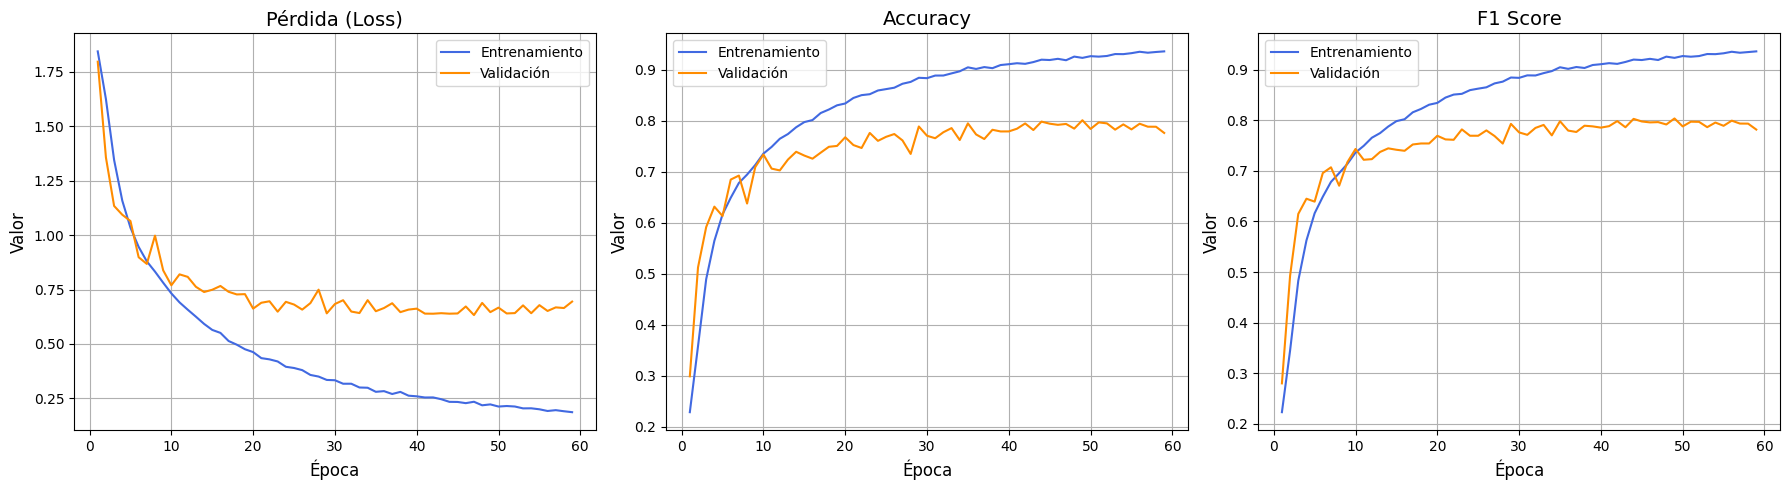

In [53]:
plot_train_results_from_json(json_file='cnn_train_data_final.json')

## 3. Evaluación del Modelo

### Consigna

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.

### Evaluación

In [15]:
# Cargar el modelo final desde el archivo
model_final.load_state_dict(torch.load('cnn_final.pth', map_location=device))
model_final.eval()  # Configurar el modelo en modo evaluación
print("Modelo cargado correctamente.")

Modelo cargado correctamente.


In [26]:
def evaluate_model(model, data_loader, class_names, device, output_file='evaluation_results.json'):
    """
    Evalúa un modelo en un conjunto de datos y genera métricas de evaluación.

    Args:
        model (torch.nn.Module): Modelo a evaluar.
        data_loader (DataLoader): DataLoader del conjunto de datos.
        class_names (list): Lista de nombres de las clases.
        device (str): Dispositivo para la evaluación ('cpu' o 'cuda').
        output_file (str): Nombre del archivo JSON para guardar los resultados.

    Returns:
        None
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Generar matriz de confusión
    cm = confusion_matrix(all_targets, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Reporte de clasificación
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)

    # Guardar resultados en un archivo JSON
    results = {
        "classification_report": report,
        "confusion_matrix": cm.tolist(),
        "confusion_matrix_normalized": cm_normalized.tolist()
    }
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Resultados guardados en {output_file}")

    # Visualizar ambas matrices de confusión juntas en la misma fila
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión Absoluta
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Matriz de Confusión (Absoluta)')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Etiqueta Verdadera')

    # Matriz de Confusión Normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Matriz de Confusión (Normalizada)')
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Etiqueta Verdadera')

    plt.tight_layout()
    plt.show()

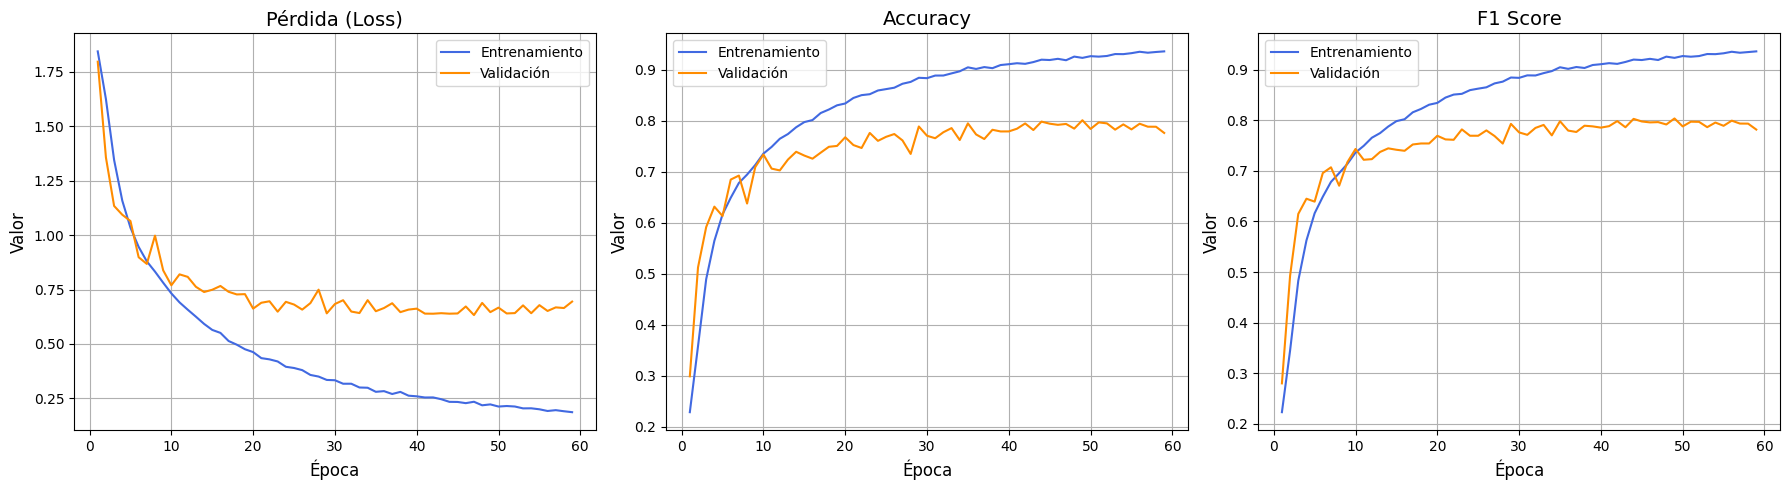

In [23]:
plot_train_results_from_json(json_file='cnn_train_data_final.json')

Resultados guardados en evaluation_results.json


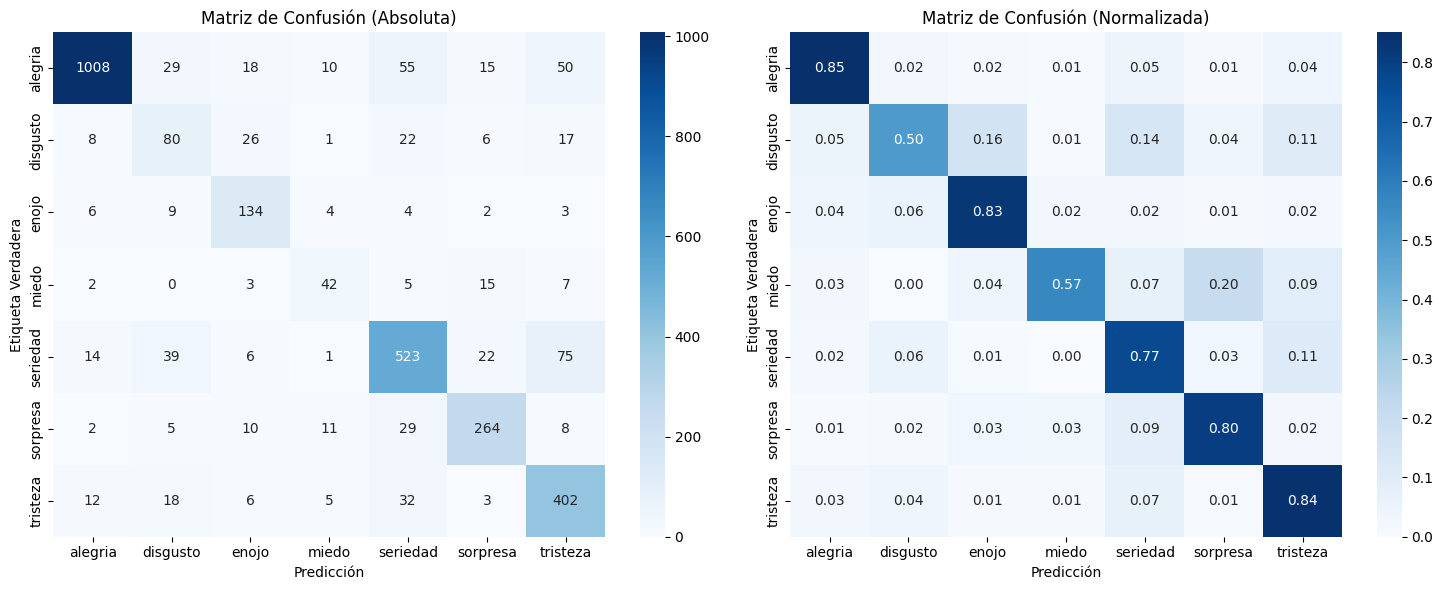

In [27]:
evaluate_model(model_final, test_loader, test_dataset.classes, device, output_file='evaluation_results.json')

In [20]:
def generate_classification_report(model, data_loader, class_names, device):
    """
    Genera un informe de clasificación para el conjunto de test.

    Args:
        model (torch.nn.Module): Modelo a evaluar.
        data_loader (DataLoader): DataLoader del conjunto de test.
        class_names (list): Lista de nombres de las clases.
        device (str): Dispositivo para la evaluación ('cpu' o 'cuda').

    Returns:
        dict: Diccionario con métricas de evaluación.
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels, reduction='sum')  # Calcular pérdida
            total_loss += loss.item()
            preds = torch.argmax(outputs, axis=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calcular métricas
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    report = classification_report(all_targets, all_preds, target_names=class_names)

    # Imprimir resultados
    print("Classification Report:")
    print(report)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Loss: {avg_loss:.4f}")

    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "loss": avg_loss,
        "classification_report": report
    }

# Ejemplo de uso
results = generate_classification_report(model_final, test_loader, test_dataset.classes, device)

Classification Report:
              precision    recall  f1-score   support

     alegria       0.96      0.85      0.90      1185
    disgusto       0.44      0.50      0.47       160
       enojo       0.66      0.83      0.73       162
       miedo       0.57      0.57      0.57        74
    seriedad       0.78      0.77      0.77       680
    sorpresa       0.81      0.80      0.80       329
    tristeza       0.72      0.84      0.77       478

    accuracy                           0.80      3068
   macro avg       0.70      0.74      0.72      3068
weighted avg       0.81      0.80      0.80      3068

Accuracy: 0.7995
F1 Score (weighted): 0.8036
Loss: 0.5918


 ## 4. Prueba con Imágenes Nuevas

### Consigna

Subir al menos 3 imágenes personales (con el rostro de ustedes o de otras personas), que no formen parte del dataset de entrenamiento ni de testeo.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo preprocesamiento que se usó para el dataset.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original (preprocesada)

  - La clase inferida por el modelo

- Redactar conclusiones y comentarios finales

### Inferencia en nuevas imagenes

In [72]:
def inferencia(model, dataset_path, transform, class_names, device) -> tuple:
    """
    Realiza inferencia sobre imágenes en una carpeta.

    Args:
        model (torch.nn.Module): Modelo entrenado.
        dataset_path (str): Ruta a la carpeta con las imágenes.
        transform (torchvision.transforms.Compose): Transformaciones a aplicar a las imágenes.
        class_names (list): Lista de nombres de las clases.
        device (str): Dispositivo para la inferencia ('cpu' o 'cuda').

    Returns:
        Tuple
    """
    model.eval()
    model.to(device)

    # Cargar imágenes de la carpeta
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    images = []
    labels = []

    for image_file in image_files:
        image_path = os.path.join(dataset_path, image_file)
        image = Image.open(image_path).convert('L')  # Convertir a escala de grises
        image = image.resize((100, 100))  # Redimensionar a 100x100
        
        # Aplicar transformaciones
        input_tensor = transform(image).unsqueeze(0).to(device)  # Añadir batch dimension

        # Realizar inferencia
        with torch.no_grad():
            output = model(input_tensor)
            predicted_label = torch.argmax(output, axis=1).item()
            labels.append(class_names[predicted_label])
            images.append(image)
    return images, labels, class_names

def resultados_inferencia(images, labels, class_names):
    """
    Muestra las imágenes con sus etiquetas de clasificación.

    Args:
        images (list): Lista de imágenes.
        labels (list): Lista de etiquetas predichas.
        class_names (list): Lista de nombres de las clases.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))

    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Predicción: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

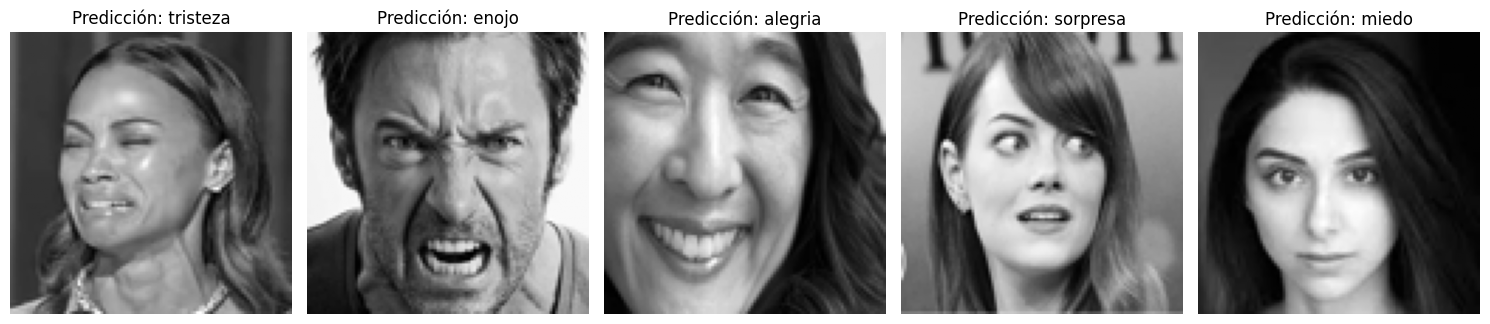

In [73]:
# Ejemplo de uso
external_dataset_path = "external_eval_dataset"
imagenes, etiquetas, clases = inferencia(model_final, external_dataset_path, test_transform, test_dataset.classes, device)
resultados_inferencia(imagenes, etiquetas, clases)


### Conclusiones

#### TODO:
- Integrar funciones auxiliares, hacerles comentarios y agregar texto explicativo
- Ahondar mas en explicar como son las dimensiones de las redes
- Agregar conclusiones finales


Se podria haber usado un early stopping mas temprano ya que hay leves indicion de overfitting por separacion en loss plot de train / val

Diminishing Returns
A partir de cierto punto, más augmentación no mejora o incluso puede empeorar el rendimiento si genera ejemplos irreales o introduce ruido.

Data augmentation: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

8,000 imágenes	24k – 40k (3×–5×)	Hasta ~50k si hay diversidad y balance